# Statistical Analysis of Image Deblurring Methods

This notebook analyzes the performance of different deblurring methods (Pseudoinverse, Wiener, DeblurGANv2) using a comprehensive statistical approach. We will explore descriptive statistics, hypothesis testing, confidence intervals, regression analysis, and visualizations to understand the strengths and weaknesses of each method.


### Single image example

In this section, we show a single-image comparison example using the Wiener deblurring method (with and without kernel knowledge). The `show_comparison` function displays the original image and the deblurred results for different blur types, allowing for an intuitive assessment of the method's effect.
As can be seen from the images, if the method knows the blur kernel, the deblurring result is visibly better compared to the case where the kernel is not known.

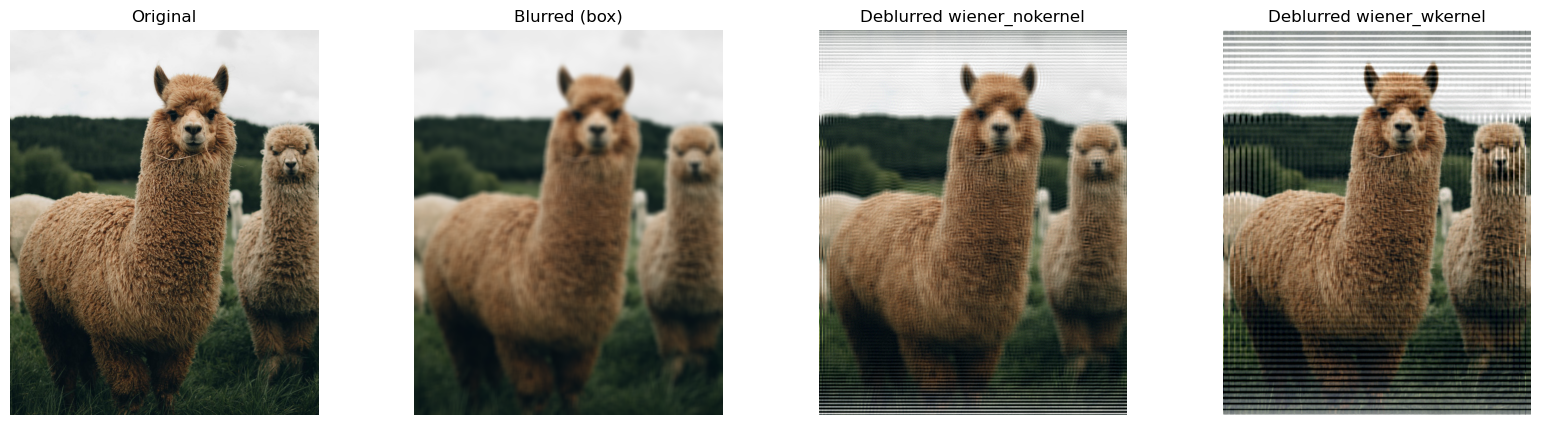

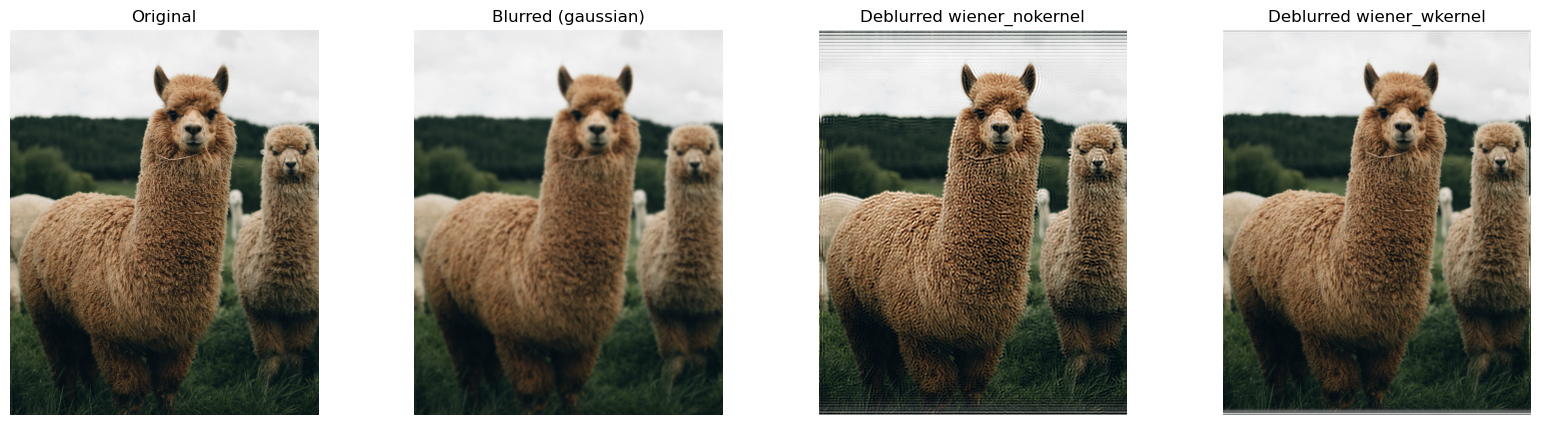

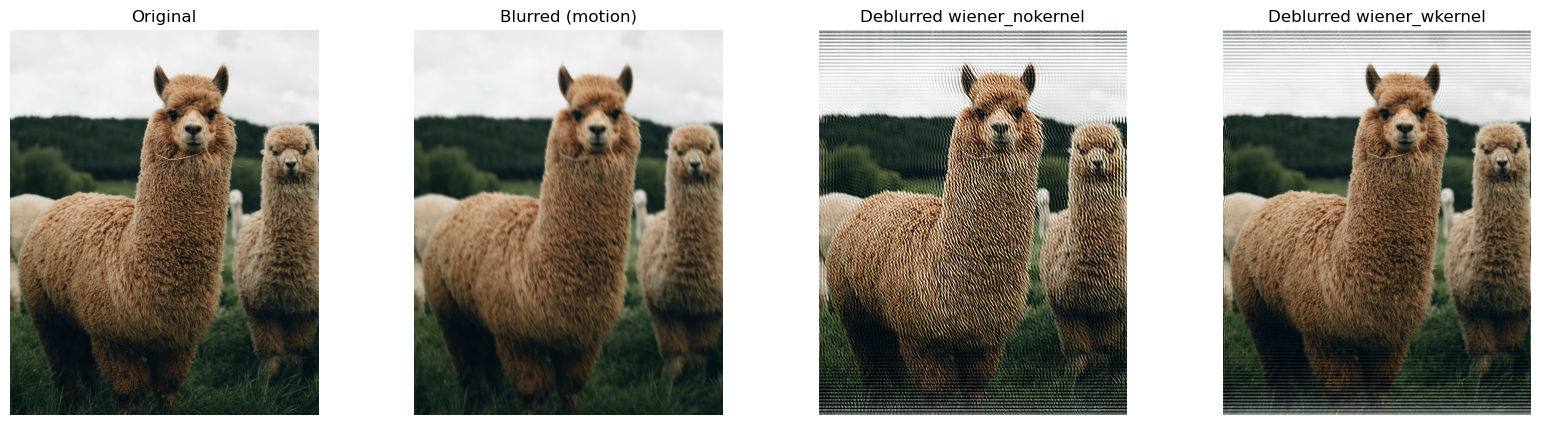

In [1]:
from common.img_output import show_comparison
from common.config import BLUR_TYPES

single_image_key = "000000845"
single_image_method = "wiener"

show_comparison(
    key=single_image_key, 
    method=single_image_method, 
    blur_types=BLUR_TYPES, 
    cropped=False
)


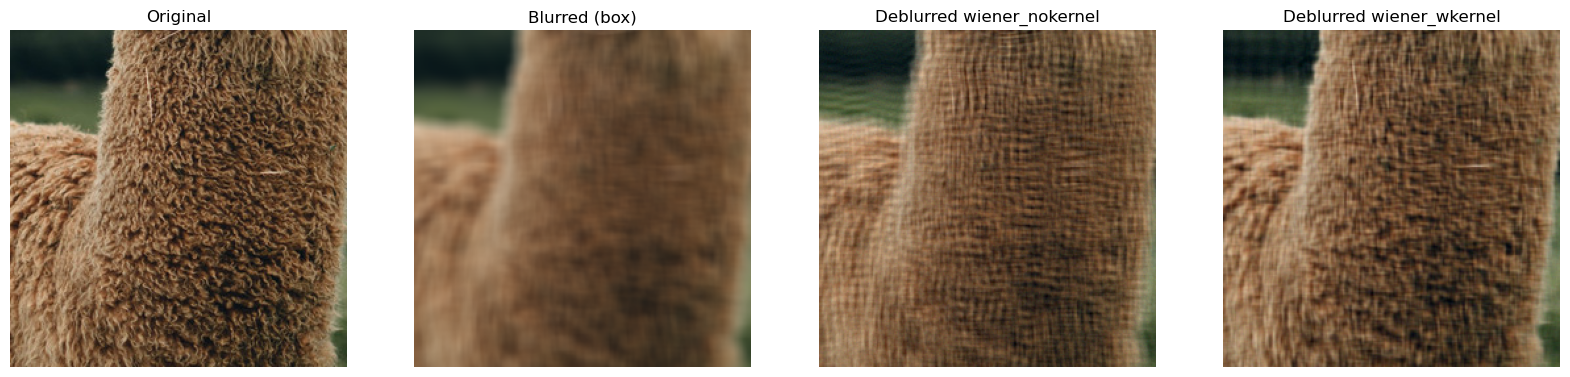

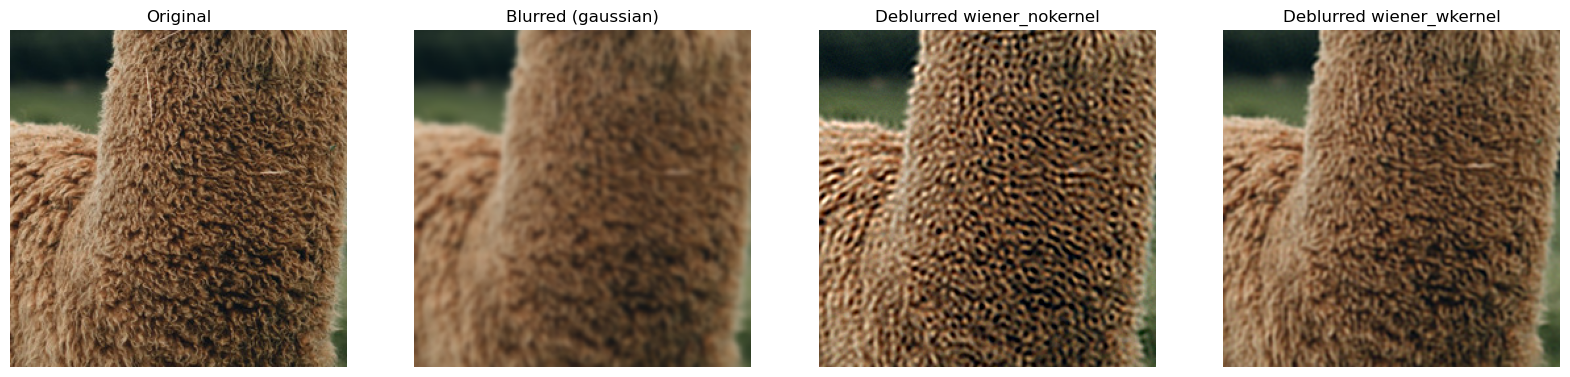

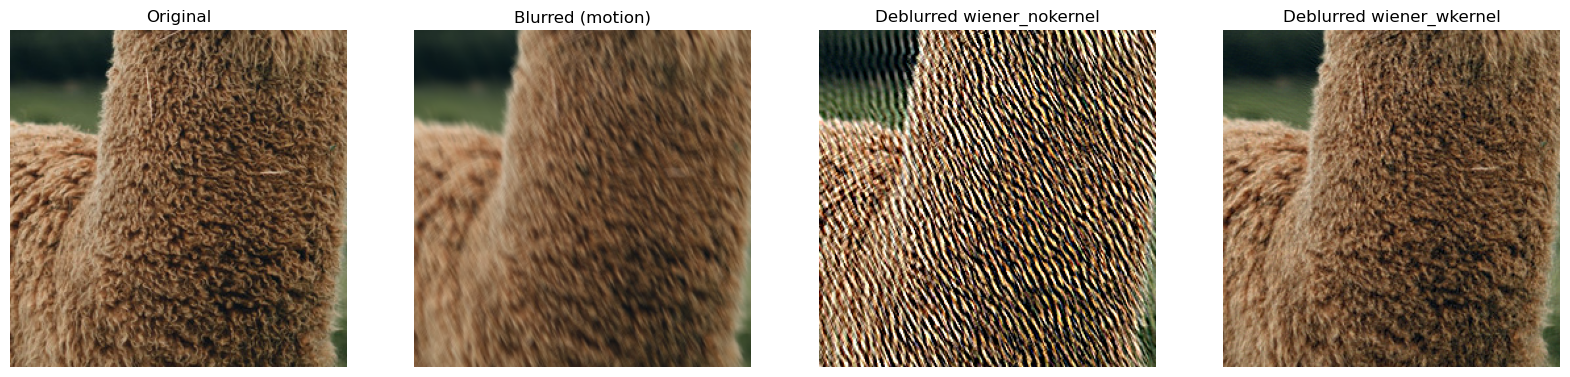

In [2]:
show_comparison(
    key=single_image_key, 
    method=single_image_method, 
    blur_types=BLUR_TYPES, 
    cropped=True
)

### Data Loading and Preprocessing

In this section, we load the original image dataset and the metric results for each deblurring method. The original dataframe is merged with each method's metrics dataframe using the image key. For each approach, we compute the average value of each metric across all blur types (box, gaussian, motion), resulting in a single metric column per method. This preprocessing step ensures that the data is ready for subsequent statistical analysis and comparisons.

In [3]:
import pandas as pd
import numpy as np

from common.config import IDPA_DATASET, WIENER_NOKERNEL_DATASET, WIENER_WKERNEL_DATASET, DEBLURGANV2_DATASET, PSEUDOINVERSE_NOKERNEL_DATASET, PSEUDOINVERSE_WKERNEL_DATASET
from common.config import METRIC_TYPES, BLUR_TYPES

original_df = pd.read_parquet(IDPA_DATASET).dropna()

dfs = {
    'pseudoinverse_nokernel': pd.read_parquet(PSEUDOINVERSE_NOKERNEL_DATASET),
    'pseudoinverse_wkernel': pd.read_parquet(PSEUDOINVERSE_WKERNEL_DATASET),
    'wiener_nokernel': pd.read_parquet(WIENER_NOKERNEL_DATASET),
    'wiener_wkernel': pd.read_parquet(WIENER_WKERNEL_DATASET),
    'deblurganv2': pd.read_parquet(DEBLURGANV2_DATASET)
}

print(f"Image parameters: {original_df.shape}")
display(original_df.head(3))

print(f"Metrics for deblurganv2: {dfs["deblurganv2"].shape}")
display(dfs["deblurganv2"].head(3))

for k in dfs.keys():
    dfs[k] = original_df.merge(dfs[k], on='key')

for df in dfs.values():
    for metric in METRIC_TYPES:
        cols = [f'{metric}_{b}' for b in BLUR_TYPES if f'{metric}_{b}' in df.columns]
        df[metric] = df[cols].mean(axis=1)

Image parameters: (950, 16)


url  category        key  \
2  http://411posters.com/wp-content/uploads/2011/...    poster  000000382   
5  http://a.mktgcdn.com/p/0LhPt4Nq5I-vk_mT8U64np5...  withchar  000000931   
6  http://a1.espncdn.com/photo/2012/1113/mag_odog...   complex  000000558   

    width  height exif  aspect_ratio       size  rms_contrast  \
2  1300.0  1728.0   {}      0.752315  3169036.0      0.373365   
5  1680.0  1120.0   {}      1.500000  3369749.0      0.302635   
6  2048.0  1280.0   {}      1.600000  3899907.0      0.220292   

   sobel_edge_strength  canny_edge_density  box_size  gaussian_sigma  \
2            54.414061            0.139681      14.0        2.079159   
5            61.659178            0.114193       5.0        0.966656   
6            60.462335            0.090309      12.0        2.335230   

   gaussian_size  motion_length  motion_angle  
2           13.0           13.0    232.710817  
5            7.0           17.0    112.800705  
6           15.0           16.0    152.963697

Metrics for deblurganv2: (950, 16)


key  proctime_box  proctime_gaussian  proctime_motion  ssim_box  \
0  000000000      0.771006           0.227473         0.227028  0.624878   
1  000000002      0.243786           0.229896         0.233648  0.592647   
2  000000003      0.220997           0.182720         0.180572  0.716148   

    psnr_box  lpips_box  gmsd_box  ssim_gaussian  psnr_gaussian  \
0  21.736350   0.063853  0.269811       0.618547      21.525129   
1  22.730560   0.006872  0.227930       0.655491      23.634710   
2  25.098564   0.004474  0.189143       0.540464      21.949155   

   lpips_gaussian  gmsd_gaussian  ssim_motion  psnr_motion  lpips_motion  \
0        0.089766       0.278274     0.789718    24.130607      0.005149   
1        0.010482       0.216396     0.536058    21.578249      0.040192   
2        0.144286       0.256134     0.667576    23.922039      0.035748   

   gmsd_motion  
0     0.174958  
1     0.224285  
2     0.192016

## 5. Descriptive statistics and Data exploration

In the following cells, we present descriptive statistics for the image dataset and the deblurring metrics obtained with DeblurGANv2. We display summary statistics for the original image features and for the main quality metrics (e.g., SSIM, LPIPS) computed on motion-blurred images. This provides an overview of the data distribution and helps identify trends or anomalies before proceeding with further statistical analysis.

In [4]:
print("Image characteristics")
display(original_df.describe())

print("Metrics for the approach (deblurganv2)")
display(dfs["deblurganv2"][[f"{x}_motion" for x in METRIC_TYPES]].describe())

Image characteristics


width       height  aspect_ratio          size  rms_contrast  \
count   950.000000   950.000000    950.000000  9.500000e+02    950.000000   
mean   1556.865263  1361.677895      1.215505  3.510588e+06      0.241307   
std     461.015906   434.723050      0.383402  1.992244e+06      0.054723   
min     170.000000   117.000000      0.463392  7.694000e+03      0.060424   
25%    1223.000000  1080.000000      0.800500  2.274401e+06      0.204291   
50%    1500.000000  1280.000000      1.333333  3.223864e+06      0.239974   
75%    1920.000000  1600.000000      1.500000  4.179430e+06      0.277998   
max    4000.000000  4066.000000      3.200000  1.768750e+07      0.430649   

       sobel_edge_strength  canny_edge_density    box_size  gaussian_sigma  \
count           950.000000          950.000000  950.000000      950.000000   
mean             63.759947            0.128991   10.117895        2.199617   
std              25.274638            0.057644    3.151395        0.995533   
min               8.266673            0.000000    5.000000        0.515940   
25%              45.575302            0.088474    7.000000        1.348071   
50%              61.044392            0.123753   10.000000        2.155779   
75%              78.197440            0.162452   13.000000        3.062990   
max             203.722492            0.373182   15.000000        3.998513   

       gaussian_size  motion_length  motion_angle  
count     950.000000     950.000000    950.000000  
mean       13.461053      17.590526    183.191937  
std         5.549477       7.629577    103.763953  
min         5.000000       5.000000      0.618597  
25%         9.000000      11.000000     91.414728  
50%        13.000000      18.000000    181.171951  
75%        19.000000      24.000000    272.798978  
max        21.000000      30.000000    359.313659

Metrics for the approach (deblurganv2)


proctime_motion  ssim_motion  psnr_motion  lpips_motion  gmsd_motion
count       950.000000   950.000000   950.000000    950.000000   950.000000
mean          0.272145     0.649029    21.910387      0.038359     0.195934
std           0.791852     0.139076     3.229507      0.046682     0.039911
min           0.043471     0.053819     9.067159      0.000395     0.054666
25%           0.176843     0.566727    19.672574      0.008121     0.171531
50%           0.214353     0.669297    21.856127      0.025873     0.198080
75%           0.272549     0.746818    23.917755      0.051549     0.225189
max          23.681326     0.960551    34.828347      0.458100     0.321087

Noticing that for the DeblurGANv2 metrics, the maximum value of `proctime_motion` is 23.68 while the 75th percentile is only 0.27, we decided to analyze the images with the highest processing times.  
We observed a clear correlation between image dimensions (height, width and thus size) and processing time: higher-resolution images require more processing time. Therefore, we removed the outliers with the highest processing times and visualized pairplot matrices to illustrate the relationship between processing time and image size characteristics.

In [5]:
top_proctime_df = dfs["deblurganv2"].nlargest(5, "proctime")[["key", "proctime", "size", "width", "height"]]

top_proctime_df

key   proctime        size   width  height
680  000000478  24.208056  17687502.0  4000.0  4000.0
319  000000581   3.676692   7749483.0  2714.0  4066.0
515  000000352   2.718421  14886231.0  3840.0  2160.0
375  000000337   2.566817  16230722.0  3840.0  2160.0
331  000001179   2.377672  12103231.0  3500.0  2113.0

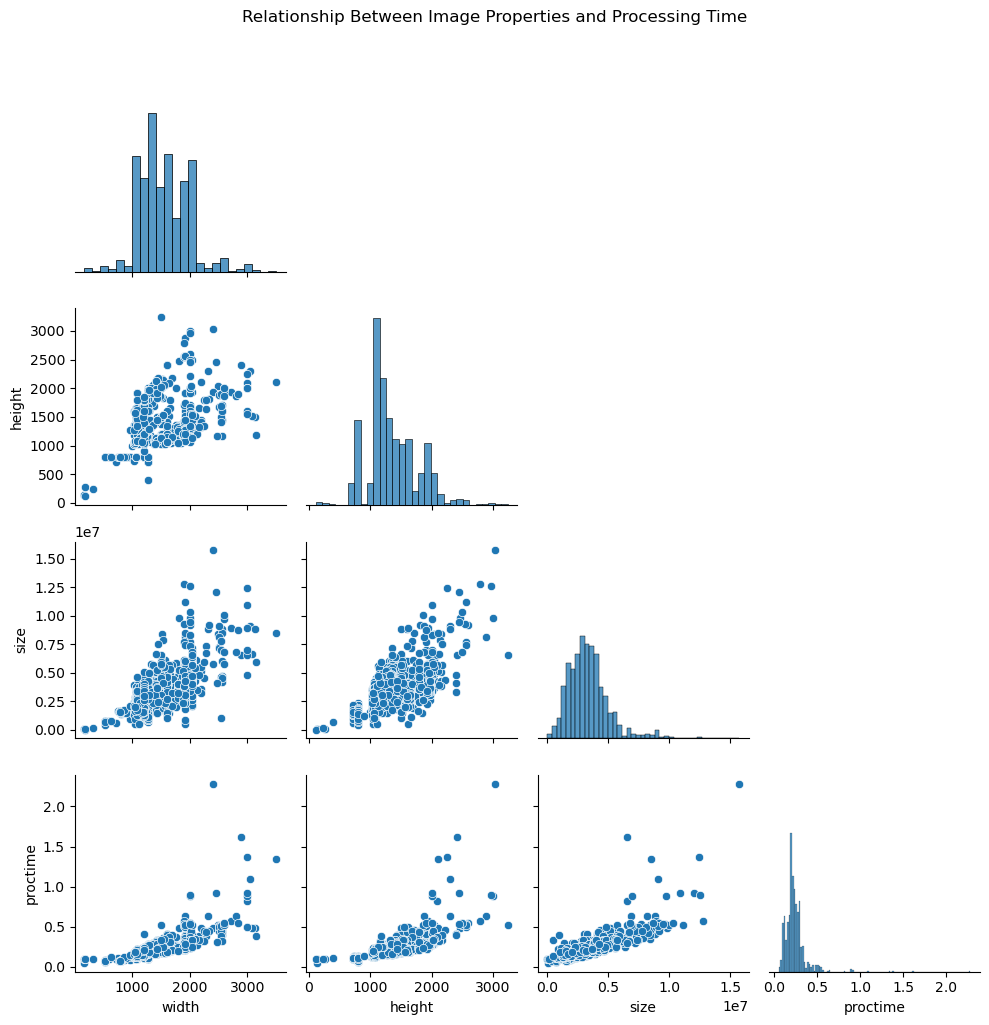

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_cols = ['width', 'height', 'size', 'proctime']

outlier_idxs = top_proctime_df.index

for df_name in dfs.keys():
    dfs[df_name] = dfs[df_name].drop(outlier_idxs)

g = sns.pairplot(dfs['deblurganv2'][plot_cols], diag_kind='hist', corner=True)
plt.suptitle('Relationship Between Image Properties and Processing Time', y=1.02)
plt.tight_layout()
plt.show()

We explore the distribution and relationships of the metrics (such as SSIM, LPIPS, GMSD, PSNR and processing time) for the DeblurGANv2 method. We visualize the metrics using pairplot matrices to identify potential correlations and trends. This step provides an overview of the metric distributions and their interdependencies, serving as a foundation for further statistical analysis and hypothesis testing.

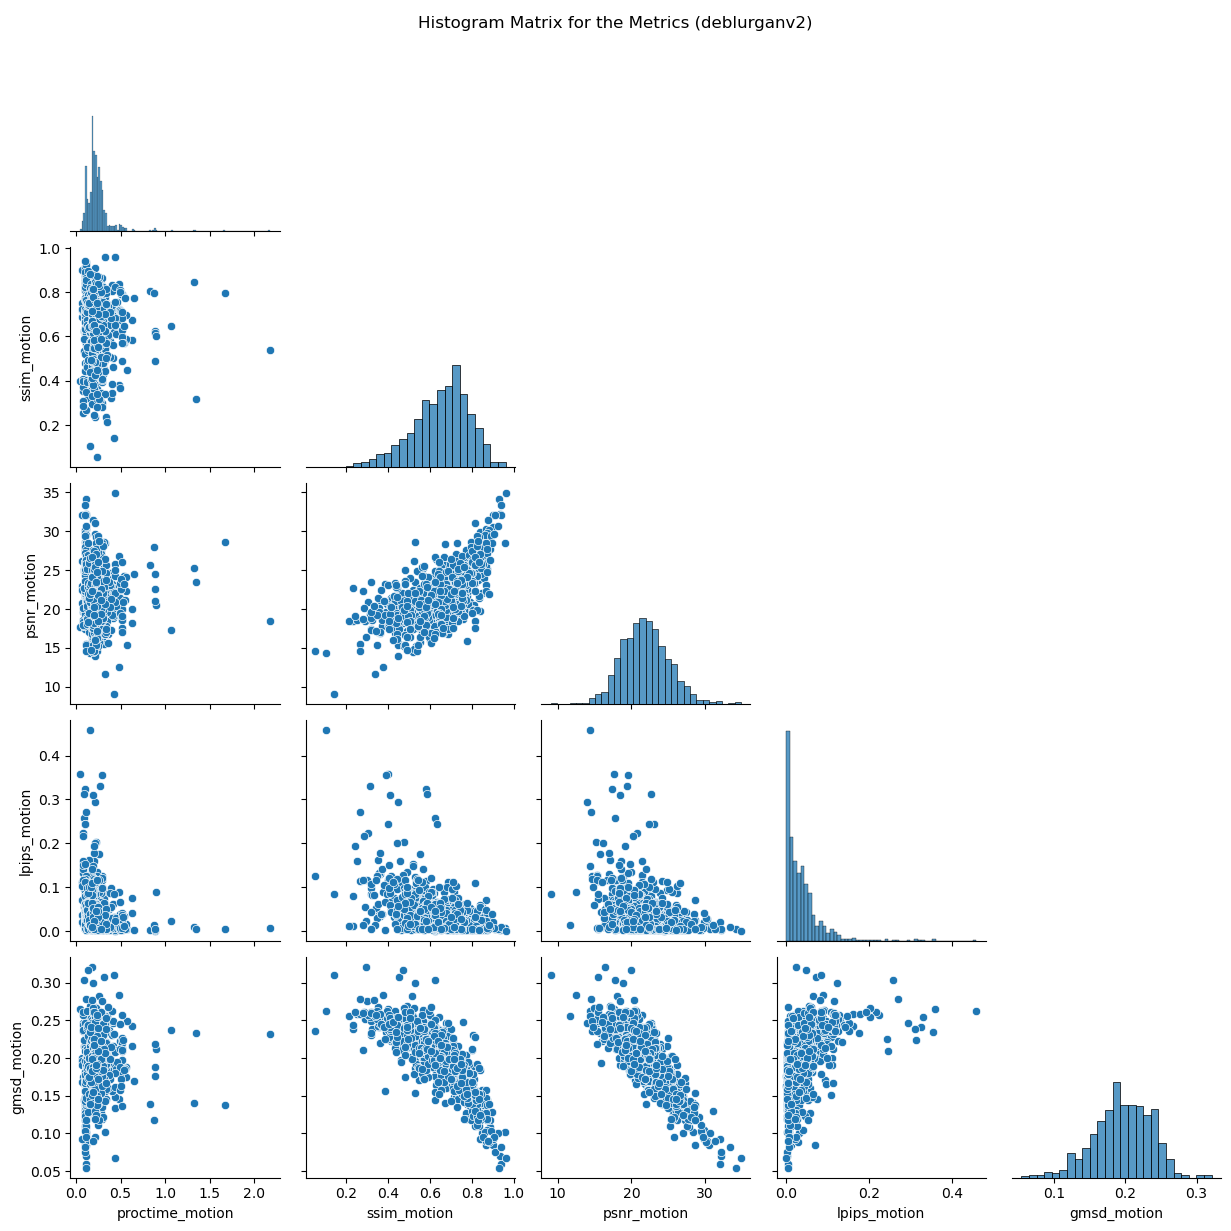

In [7]:
metric_cols = [f'{metric}_motion' for metric in METRIC_TYPES if f'{metric}' in dfs['deblurganv2'].columns]
plot_df_wk = dfs['deblurganv2'][metric_cols].copy()

sns.pairplot(plot_df_wk, diag_kind='hist', corner=True)
plt.suptitle('Histogram Matrix for the Metrics (deblurganv2)')
plt.show()

To confirm our assumptions about the correlation of the metrics we compute a correlation heat map for each metric across all methods. The correlation is computed using the Pearson coefficient.

The Pearson correlation coefficient, denoted as $\rho$ for the population and $r$ for the sample, measures the linear relationship between two variables $X$ and $Y$. It is calculated as:

$$
\rho = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

where $\mathrm{Cov}(X, Y)$ is the covariance between $X$ and $Y$, and $\sigma_X$, $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively. The value of $r$ ranges from $-1$ (perfect negative linear correlation) to $+1$ (perfect positive linear correlation), with $0$ indicating no linear correlation.


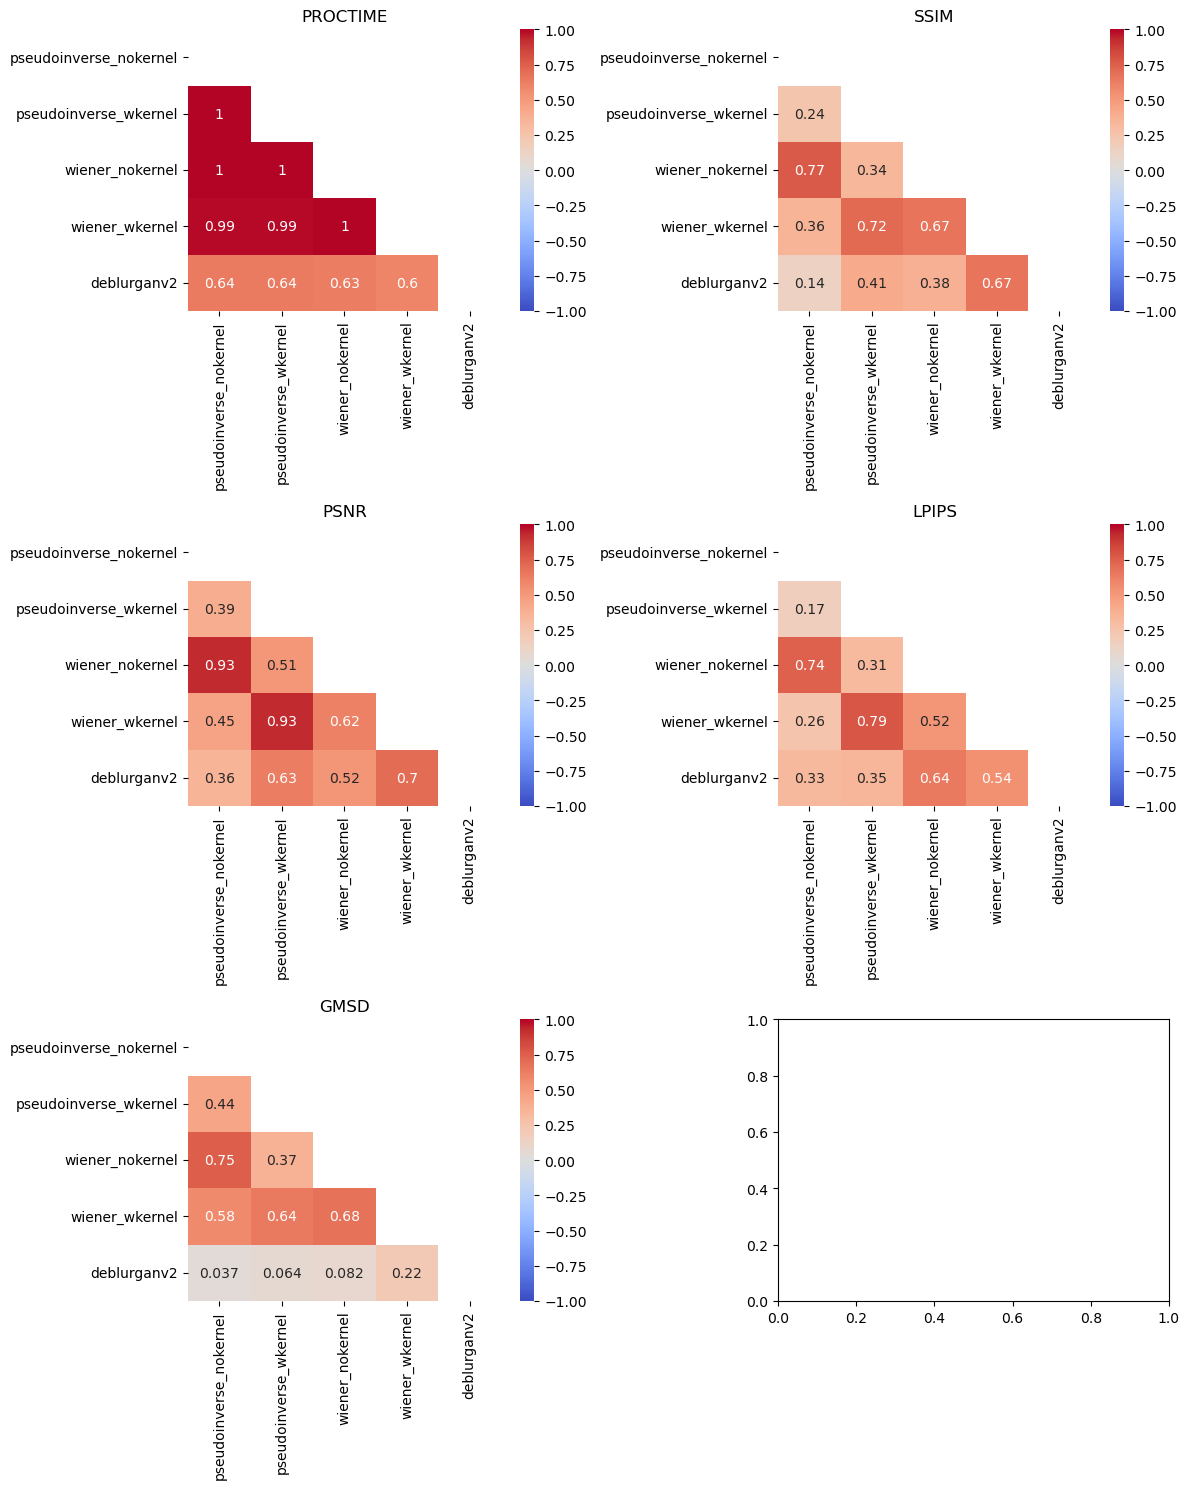

In [8]:
n_metrics = len(METRIC_TYPES)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for i, metric in enumerate(METRIC_TYPES):
    data = pd.DataFrame({
        method: df[metric] for method, df in dfs.items()
    })
    corr = data.corr()**2
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, ax=axes[i])
    axes[i].set_title(metric.upper())

plt.tight_layout()
plt.show()

We generate boxplots for each metric across all deblurring methods. This visualization allows for a direct comparison of the distribution and variability of each metric among the different approaches. By examining these boxplots, we can identify which methods tend to perform better or worse according to each metric, and observe the presence of outliers or differences in metric variability.

As shown by the boxplots, DeblurGANv2 consistently outperforms the two classical methods across all metrics:

- It is the fastest method in terms of processing time (`proctime`).
- For `ssim` and `psnr`, DeblurGANv2 achieves the highest values (higher is better).
- For `lpips` and `gmsd`, it obtains the lowest values (lower is better).

Additionally, for both classical methods, results are slightly better when the blur kernel is known compared to when it is not.

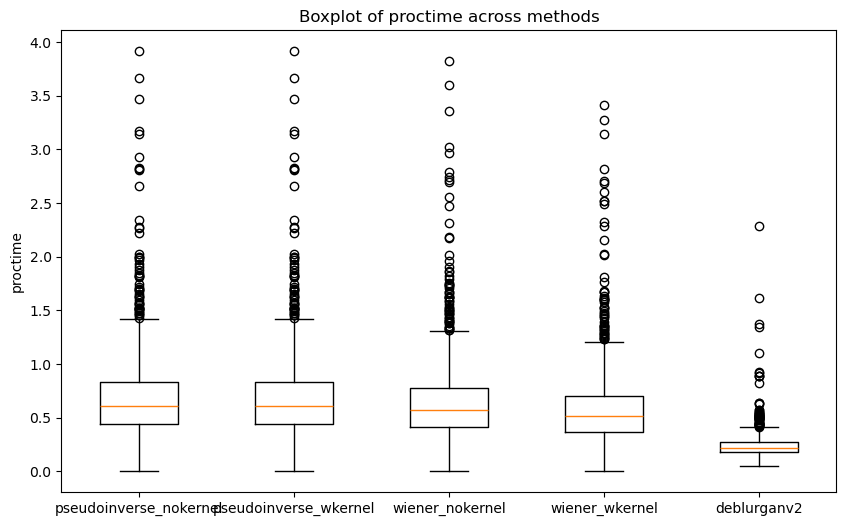

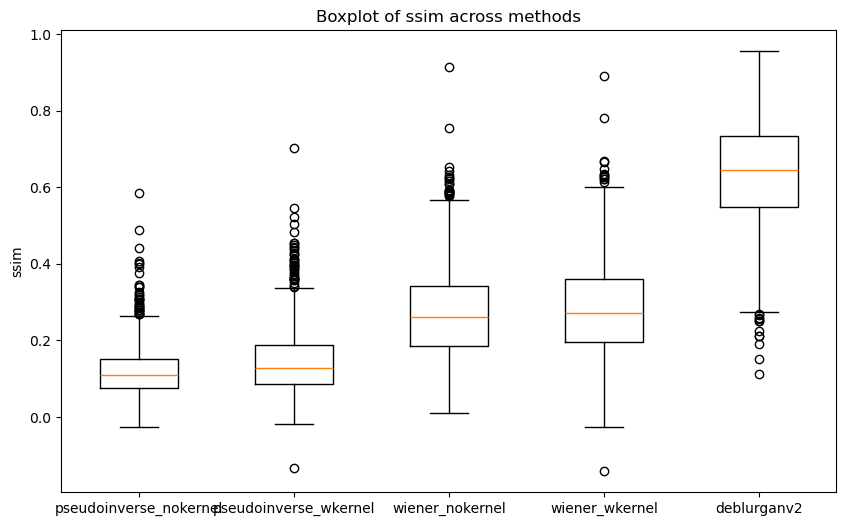

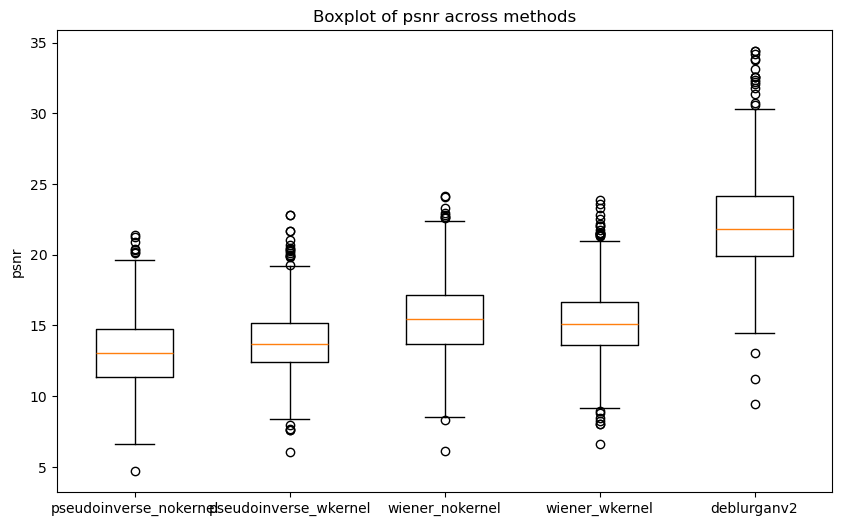

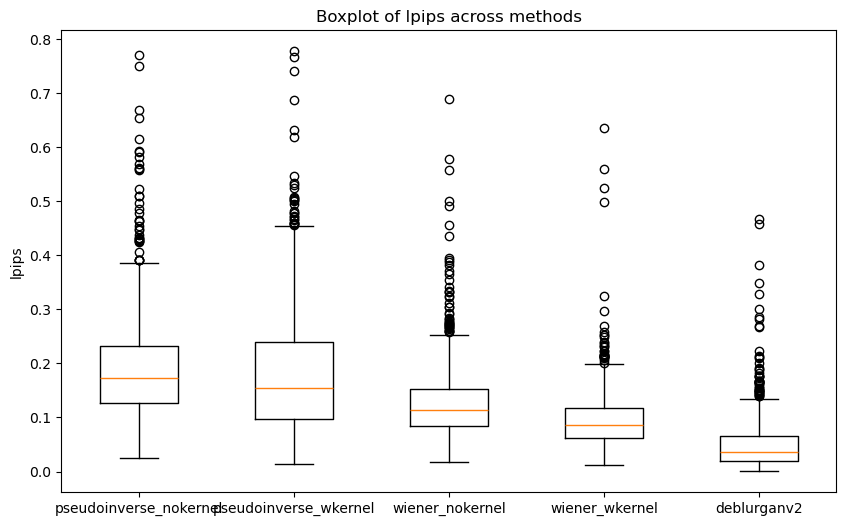

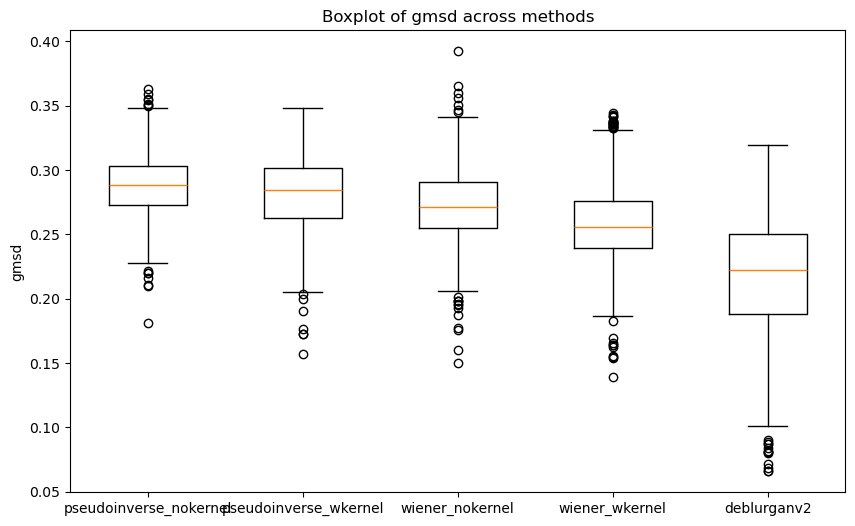

In [9]:
for metric in METRIC_TYPES:
    plt.figure(figsize=(10, 6))
    data = [df[metric] for df in dfs.values()]
    plt.boxplot(data, tick_labels=dfs.keys())
    plt.title(f'Boxplot of {metric} across methods')
    plt.ylabel(metric)
    plt.show()

We confirm the assumptions about performance by comparing the means of each metric.


In [10]:
display(pd.DataFrame({
    method: [df[metric].mean() for metric in METRIC_TYPES]
    for method, df in dfs.items()
}, index=METRIC_TYPES))

pseudoinverse_nokernel  pseudoinverse_wkernel  wiener_nokernel  \
proctime                0.696501               0.696501         0.656819   
ssim                    0.121407               0.146745         0.274046   
psnr                   13.096717              13.848694        15.533071   
lpips                   0.191347               0.180354         0.127446   
gmsd                    0.288346               0.281298         0.272900   

          wiener_wkernel  deblurganv2  
proctime        0.595026     0.238416  
ssim            0.283355     0.635124  
psnr           15.165267    22.096709  
lpips           0.095419     0.050512  
gmsd            0.258022     0.216971

## 6/7. Hypothesis Testing and Power Analysis / Confidence Intervals

Now we compare the performance of methods using hypothesis tests and confidence intervals on average metrics.

### Hypothesis Testing 1: Paired t-test (Wiener with kernel vs without kernel) — SSIM

We want to verify whether using the kernel in the Wiener method leads to improved performance compared to the version without kernel, considering the **SSIM** metric.

**Definitions:**
- $X_1$: SSIM for Wiener **with kernel**
- $X_2$: SSIM for Wiener **without kernel**
- $D = X_1 - X_2$: difference in metrics for each image

**Hypotheses:**

- $H_0$: $\mu_D \leq 0$  
    (No average improvement, or Wiener with kernel performs the same or worse than the version without kernel)
- $H_1$: $\mu_D > 0$  
    (Wiener with kernel has a higher mean SSIM than the version without kernel)

**Test used:**  
Paired t-test (one-tailed, left)

**Results interpretation:**  
Based on the computed t statistic, we can reject the null hypothesis ($H_0$) and conclude that the Wiener method with kernel achieves significantly higher mean SSIM values compared to the version without kernel. This conclusion is further supported by the p-value, which is lower than the chosen significance level ($\alpha$), confirming the statistical significance of the result.

In [11]:
from scipy.stats import ttest_rel, t

METRIC = "ssim"

ssim_wk = dfs["wiener_wkernel"][METRIC]
ssim_nk = dfs["wiener_nokernel"][METRIC]

# 1. Hypotheses
print("1. Hypotheses:")
print(f"   H0: μ_d <= 0 (no difference or Wiener with kernel is not better in {METRIC} compared to without kernel)")
print(f"   H1: μ_d > 0 (Wiener with kernel has HIGHER {METRIC})")

# 2. Acceptance region (one-tailed, right)
alpha = 0.01
n = len(ssim_wk)
df = n - 1
t_critical = t.ppf(1 - alpha, df)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if t > {t_critical:.4f} (alpha = {alpha})")

# 3. Test statistic
stat, p_value_one_tailed = ttest_rel(ssim_wk, ssim_nk, alternative='greater')
print(f"\n3. Test statistic:")
print(f"   t = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if stat > t_critical:
    print(f"   Reject H0: There is evidence Wiener with kernel has HIGHER {METRIC}.")
else:
    print("   Fail to reject H0: No evidence Wiener with kernel is better.")

# 5. p-value (one-tailed, right tail)
print(f"\n5. p-value (one-tailed, right): {p_value_one_tailed:.4e}")


1. Hypotheses:
   H0: μ_d <= 0 (no difference or Wiener with kernel is not better in ssim compared to without kernel)
   H1: μ_d > 0 (Wiener with kernel has HIGHER ssim)

2. Acceptance region:
   Reject H0 if t > 2.3303 (alpha = 0.01)

3. Test statistic:
   t = 3.7677

4. Decision:
   Reject H0: There is evidence Wiener with kernel has HIGHER ssim.

5. p-value (one-tailed, right): 8.7499e-05


### Paired confidence interval

The **confidence interval** estimate for the mean of paired differences is:

$$
\bar{d} \pm t_{n-1,\,1-\alpha/2} \cdot \frac{s_d}{\sqrt{n}}
$$

where:
- $\bar{d}$ is the mean of the differences,
- $s_d$ is the standard deviation of the differences,
- $n$ is the number of pairs,
- $t_{n-1,\,1-\alpha/2}$ is the quantile of the Student's t-distribution with $n-1$ degrees of freedom.

**Results interpretation:**  
With 99% confidence, the true mean difference between SSIM (Wiener with kernel) and SSIM (Wiener without kernel) lies within the calculated interval. Since this confidence interval does not include zero, we can conclude that using the kernel in the Wiener method leads to a statistically significant improvement in quality (SSIM) compared to the version without kernel.

In [12]:
import numpy as np
from scipy.stats import t

# 99% confidence interval for the mean of the differences D = X1 - X2 (SSIM Wiener with kernel - without kernel)

D = ssim_wk - ssim_nk
D = D.dropna()
n = len(D)
mean_D = D.mean()
std_D = D.std()
se_D = std_D / np.sqrt(n)
confidence_level = 0.99
alpha = 1 - confidence_level
df = n - 1

t_critical = t.ppf(1 - alpha/2, df)
margin_error = t_critical * se_D
ci_lower = mean_D - margin_error
ci_upper = mean_D + margin_error

print(f"99% confidence interval for the mean of the differences (D = SSIM_wk - SSIM_nk):")
print(f"[{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Mean of the differences: {mean_D:.4f}")
print(f"Does the interval contain zero? {'Yes' if ci_lower <= 0 <= ci_upper else 'No'}")

99% confidence interval for the mean of the differences (D = SSIM_wk - SSIM_nk):
[0.0029, 0.0157]
Mean of the differences: 0.0093
Does the interval contain zero? No


### Hypothesis Testing 2: Independent t-test (DeblurGANv2 vs Wiener without kernel) — LPIPS (Motion Blur Only)

We want to verify whether the average perceptual quality (LPIPS) for **motion blur** obtained with DeblurGANv2 is significantly different (lower, thus better) compared to Wiener without kernel.

**Definitions:**
- $X_1$: LPIPS (motion blur) for DeblurGANv2
- $X_2$: LPIPS (motion blur) for Wiener without kernel

**Hypotheses:**

- $H_0$: $\mu_1 \geq \mu_2$  
    (DeblurGANv2 has the same or higher LPIPS than Wiener without kernel for motion blur)
- $H_1$: $\mu_1 < \mu_2$  
    (DeblurGANv2 has a lower, thus better, LPIPS than Wiener without kernel for motion blur)

**Test used:**  
Independent two-sample t-test (one-tailed, left)

**Results interpretation:**  
Based on the computed t statistic, we can reject the null hypothesis ($H_0$) and conclude that the DeblurGANv2 method achieves significantly lower lpips_motion values compared to Wiener without kernel. This conclusion is further supported by the p-value, which is lower than the chosen significance level ($\alpha$), confirming the statistical significance of the result.

In [13]:
from scipy.stats import ttest_ind, t

metric = "lpips_motion"

lpips_dg = dfs["deblurganv2"][metric]
lpips_nk = dfs["wiener_nokernel"][metric]

# 1. Hypotheses
print("1. Hypotheses:")
print(f"   H0: μ1 >= μ2 (DeblurGANv2 has the same or HIGHER {metric} than Wiener no kernel)")
print(f"   H1: μ1 < μ2 (DeblurGANv2 has LOWER {metric})")

# 2. Acceptance region (one-tailed, left)
alpha = 0.01
n1, n2 = len(lpips_dg), len(lpips_nk)
s1 = lpips_dg.std()
s2 = lpips_nk.std()
df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
t_critical = t.ppf(alpha, df)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if t < {t_critical:.4f} (alpha = {alpha})")

# 3. Test statistic
stat, p_value_one_tailed = ttest_ind(lpips_dg, lpips_nk, equal_var=False, alternative='less')
print(f"\n3. Test statistic:")
print(f"   t = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if stat < t_critical:
    print(f"   Reject H0: There is evidence DeblurGANv2 has LOWER {metric}.")
else:
    print("   Fail to reject H0: No evidence DeblurGANv2 is better.")

# 5. p-value (one-tailed, left tail)
print(f"\n5. p-value (one-tailed, left): {p_value_one_tailed:.4e}")

1. Hypotheses:
   H0: μ1 >= μ2 (DeblurGANv2 has the same or HIGHER lpips_motion than Wiener no kernel)
   H1: μ1 < μ2 (DeblurGANv2 has LOWER lpips_motion)

2. Acceptance region:
   Reject H0 if t < -2.3292 (alpha = 0.01)

3. Test statistic:
   t = -39.2992

4. Decision:
   Reject H0: There is evidence DeblurGANv2 has LOWER lpips_motion.

5. p-value (one-tailed, left): 5.0589e-225


### Test Power Analysis (z-test approximation)

We compute the statistical power of the independent t-test comparing LPIPS (motion blur) between DeblurGANv2 and Wiener without kernel. The power of a test is the probability of correctly rejecting the null hypothesis when the alternative hypothesis is true (i.e., detecting a true effect).  
We used the z-test approximation (instead of the t-test) because, with large sample sizes, the distribution of the test statistic rapidly approaches the standard normal, making the approximation highly accurate.

**Procedure:**
- We used the observed difference between means (`delta`) and the pooled standard deviation to estimate the effect size.  
- We calculated the standard error of the difference based on the sample sizes and the pooled variance.  
- We determined the critical value (`z_alpha`) for the one-sided left-tailed test at significance level $\alpha = 0.01$.  
- We computed the power as the probability that the test statistic falls below the critical threshold under the alternative hypothesis.

**Interpretation:**  
A power close to 1 indicates a very high probability of detecting a true difference in LPIPS between the two methods, given the observed effect size and sample sizes. This means the test is highly sensitive and unlikely to miss a real effect.

In [14]:
from scipy.stats import norm
import numpy as np

n1 = len(lpips_dg)
n2 = len(lpips_nk)
alpha = 0.01

# Minimum relevant difference (delta): you can choose a value, e.g., the observed difference
delta = lpips_dg.mean() - lpips_nk.mean()

# Pooled standard deviation
s1 = lpips_dg.std()
s2 = lpips_nk.std()
s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))

# Standard error of the difference
se = s_pooled * np.sqrt(1/n1 + 1/n2)

# Critical threshold for left-tailed test
z_alpha = norm.ppf(alpha)

# Mean of the statistic under the alternative
mu_Z1 = delta / se

# Power calculation
power = norm.cdf(z_alpha, loc=mu_Z1, scale=1)

print(f"Test power (z-test approximation): {power}")

Test power (z-test approximation): 1.0


### Confidence Interval for the Difference Between Means

The **confidence interval** estimates the difference between the means of LPIPS_motion obtained with DeblurGANv2 and Wiener without kernel.  
We use the formula for the confidence interval of the difference between two independent sample means (with unequal variances, Welch’s t-test):

$$
(\bar{X}_1 - \bar{X}_2) \pm t_{df,\,1-\alpha/2} \cdot SE
$$

where:
- $\bar{X}_1$, $\bar{X}_2$ are the means of the two groups,
- $SE = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$ is the standard error of the difference,
- $t_{df,\,1-\alpha/2}$ is the quantile of the Student’s t-distribution with $df$ degrees of freedom (calculated using the Welch formula).

**Results interpretation:**  
With 99% confidence, the difference between means of LPIPS_motion (DeblurGANv2 minus Wiener without kernel) lies within the calculated interval. Since the interval is entirely negative and does not include zero, we can conclude that DeblurGANv2 achieves significantly lower (better) mean LPIPS_motion values compared to Wiener without kernel. This confirms that the observed difference is not due to chance, but reflects a real advantage of the AI method in terms of perceptual quality.

In [15]:
import numpy as np
from scipy.stats import t

X1 = lpips_dg.dropna()
X2 = lpips_nk.dropna()
n1, n2 = len(X1), len(X2)
mean1, mean2 = X1.mean(), X2.mean()
std1, std2 = X1.std(ddof=1), X2.std(ddof=1)

# Estimate of the standard error (Welch's t-test, unequal variances)
se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
mean_diff = mean1 - mean2

# Degrees of freedom (Welch-Satterthwaite equation)
df_diff = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))

# 99% confidence interval
confidence_level = 0.99
alpha = 1 - confidence_level
t_critical_diff = t.ppf(1 - alpha/2, df_diff)
margin_error_diff = t_critical_diff * se_diff
ci_lower_diff = mean_diff - margin_error_diff
ci_upper_diff = mean_diff + margin_error_diff

print(f"99% CI for mean difference (DeblurGANv2 - Wiener no kernel) on LPIPS_motion:")
print(f"[{ci_lower_diff:.4f}, {ci_upper_diff:.4f}]")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Does the interval contain zero? {'Yes' if ci_lower_diff <= 0 <= ci_upper_diff else 'No'}")

99% CI for mean difference (DeblurGANv2 - Wiener no kernel) on LPIPS_motion:
[-0.1521, -0.1334]
Mean difference: -0.1427
Does the interval contain zero? No


### Hypothesis Testing 3: Difference in Proportions — Threshold Exceedance

We want to verify whether **DeblurGANv2** exceeds a quality threshold (e.g., GMSD < 0.20) **more often** than Wiener **without kernel**, considering only the **motion blur** case.

**Definitions:**
- $p_1$: Proportion of images with GMSD_motion < 0.20 for DeblurGANv2
- $p_2$: Proportion of images with GMSD_motion < 0.20 for Wiener without kernel

**Hypotheses:**

- $H_0$: $p_1 \leq p_2$  
    (The proportions of success are equal or DeblurGANv2 is not better)
- $H_1$: $p_1 > p_2$  
    (DeblurGANv2 has a higher proportion of successes)

**Test used:**  
z-test for proportions (one-tailed, right, on GMSD_motion)

**Results interpretation:**  
The statistical test shows that the proportion of images with GMSD_motion below 0.20 is significantly higher for DeblurGANv2 compared to Wiener without kernel. The calculated z value exceeds the critical threshold and the p-value is much lower than the chosen significance level ($\alpha$), allowing us to reject the null hypothesis. This confirms that DeblurGANv2 surpasses the quality threshold more often than the classical method, highlighting a concrete advantage in perceptual quality.

In [16]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

metric = "gmsd_motion"
threshold = 0.20

# 1. Hypotheses:
print("1. Hypotheses:")
print(f"   H0: p1 <= p2 (DeblurGANv2 has the same or lower proportion of images with {metric} < {threshold} compared to Wiener no kernel)")
print(f"   H1: p1 > p2 (DeblurGANv2 has a higher proportion of images with {metric} < {threshold})")

# Calculate proportions GMSD < threshold
success_ai = (dfs['deblurganv2'][metric] < threshold).sum()
n_ai = dfs['deblurganv2'][metric].notna().sum()
success_nk = (dfs['wiener_nokernel'][metric] < threshold).sum()
n_nk = dfs['wiener_nokernel'][metric].notna().sum()

count = [success_ai, success_nk]
nobs = [n_ai, n_nk]

# 2. Acceptance region (one-tailed, right, alpha=0.05)
alpha = 0.01
z_critical = norm.ppf(1 - alpha)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if z > {z_critical:.4f} (alpha = {alpha})")

# 3. Test statistic (one-tailed, alternative='larger')
stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"\n3. Test statistic:")
print(f"   z = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if stat > z_critical:
    print("   Reject H0: DeblurGANv2 has a significantly higher proportion of successes.")
else:
    print("   Fail to reject H0: No significant evidence that DeblurGANv2 has a higher proportion.")

# 5. p-value (one-tailed)
print(f"\n5. p-value (one-tailed): {p_value:.4e}")

print(f"\nDeblurGANv2: {success_ai}/{n_ai} ({success_ai/n_ai:.2%})")
print(f"Wiener no kernel: {success_nk}/{n_nk} ({success_nk/n_nk:.2%})")


1. Hypotheses:
   H0: p1 <= p2 (DeblurGANv2 has the same or lower proportion of images with gmsd_motion < 0.2 compared to Wiener no kernel)
   H1: p1 > p2 (DeblurGANv2 has a higher proportion of images with gmsd_motion < 0.2)

2. Acceptance region:
   Reject H0 if z > 2.3263 (alpha = 0.01)

3. Test statistic:
   z = 25.1801

4. Decision:
   Reject H0: DeblurGANv2 has a significantly higher proportion of successes.

5. p-value (one-tailed): 3.3084e-140

DeblurGANv2: 496/945 (52.49%)
Wiener no kernel: 11/945 (1.16%)


### Confidence Interval for the Difference in Proportions
The **confidence interval** estimates the difference between the proportions of images that exceed a given quality threshold (e.g., GMSD_motion < 0.20) for DeblurGANv2 compared to Wiener without kernel.
We use the formula for the confidence interval of the difference between two independent proportions:

$$ (\hat{p}_1 - \hat{p}_2) \pm z_{1-\alpha/2} \cdot SE $$

where:

- $\hat{p}_1$, $\hat{p}_2$ are the observed proportions of successes in the two groups,
- $SE = \sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$ is the standard error of the difference,
- $z_{1-\alpha/2}$ is the quantile of the standard normal distribution for the chosen confidence level.

**Results interpretation:**  
With 99% confidence, the difference between proportions of images exceeding the quality threshold (DeblurGANv2 minus Wiener without kernel) lies within the calculated interval. Since this confidence interval does not include zero and is entirely positive, we can conclude that DeblurGANv2 surpasses the quality threshold significantly more often than the classical method. This confirms a real and statistically significant advantage for the AI method.

In [17]:
from statsmodels.stats.proportion import confint_proportions_2indep

# 99% confidence interval for the difference in proportions (p1 - p2)
alpha_ci = 0.01
ci_low, ci_upp = confint_proportions_2indep(
    count1=success_ai, nobs1=n_ai,
    count2=success_nk, nobs2=n_nk,
    method='wald', alpha=alpha_ci
)

print(f"99% confidence interval for the difference in proportions (DeblurGANv2 - Wiener no kernel):")
print(f"[{ci_low:.4f}, {ci_upp:.4f}]")
print(f"Observed difference: {(success_ai/n_ai - success_nk/n_nk):.4f}")
print(f"Does the interval contain zero? {'Yes' if ci_low <= 0 <= ci_upp else 'No'}")

99% confidence interval for the difference in proportions (DeblurGANv2 - Wiener no kernel):
[0.4704, 0.5560]
Observed difference: 0.5132
Does the interval contain zero? No
